In [2]:
import os
import random
import carla
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import sys
import importlib
import csv

# Add the "scripts" directory to sys.path
current_dir = os.path.dirname(os.path.abspath("__file__"))
scripts_dir = os.path.abspath(os.path.join(current_dir, 'scripts'))
sys.path.append(scripts_dir)
import LLAMAconnect as llama

In [3]:
# Connecting to CARLA
client = carla.Client('localhost', 2000)
client.set_timeout(20)
world = client.load_world('Town05_Opt') # Town01_Opt is a lighter version of Town01 with layers
world.unload_map_layer(carla.MapLayer.Foliage) # unload foliage for better perfomance 
world.unload_map_layer(carla.MapLayer.Particles) # unload particles for better performance
spectator = world.get_spectator()

In [4]:
# Blueprints and spawn points
vehicles_bp = [bp for bp in world.get_blueprint_library().filter('vehicle.*') if 'bike' not in bp.id]
spawn_points = world.get_map().get_spawn_points()

In [5]:
def destroy_vehicles():
    # Destroy all vehicles
    for actor in world.get_actors().filter('vehicle.*'):
        actor.destroy()

## Setting up sensors

### IMU settings

In [6]:
def imu_callback(data):
    global imu_df
    timestamp = data.timestamp
    acc = data.accelerometer
    gyro = data.gyroscope
    compass = data.compass

    values = [[timestamp, acc.x, acc.y, acc.z, gyro.x, gyro.y, gyro.z, np.rad2deg(compass)]]
    new_data = pd.DataFrame(values, columns=imu_df.columns)

    imu_df = pd.concat([imu_df, new_data], ignore_index=True)

In [7]:
def set_attributes_IMU(imu_bp, sensor_tick=0.01, acc_noise=0.000, gyro_std=0.000, gyro_mean=0.000):
    imu_bp.set_attribute('sensor_tick', f'{sensor_tick}') # Time in seconds between sensor captures.
    imu_bp.set_attribute('noise_accel_stddev_x', f'{acc_noise}') # Standard deviation parameter in the noise model for acceleration (X axis).
    imu_bp.set_attribute('noise_accel_stddev_y', f'{acc_noise}') # Standard deviation parameter in the noise model for acceleration (Y axis).
    imu_bp.set_attribute('noise_accel_stddev_z', f'{acc_noise}') # Standard deviation parameter in the noise model for acceleration (Z axis).
    imu_bp.set_attribute('noise_gyro_stddev_x', f'{gyro_std}') # Standard deviation parameter in the noise model for gyroscope (X axis).
    imu_bp.set_attribute('noise_gyro_stddev_y', f'{gyro_std}') # Standard deviation parameter in the noise model for gyroscope (Y axis).
    imu_bp.set_attribute('noise_gyro_stddev_z', f'{gyro_std}') # Standard deviation parameter in the noise model for gyroscope (Z axis).
    imu_bp.set_attribute('noise_gyro_bias_x', f'{gyro_mean}') # Mean parameter in the noise model for gyroscope (X axis).
    imu_bp.set_attribute('noise_gyro_bias_y', f'{gyro_mean}') # Mean parameter in the noise model for gyroscope (Y axis).
    imu_bp.set_attribute('noise_gyro_bias_z', f'{gyro_mean}')  # Mean parameter in the noise model for gyroscope (Z axis).


In [8]:
IMU_bp = world.get_blueprint_library().find('sensor.other.imu')
set_attributes_IMU(IMU_bp, sensor_tick=0.05)

### GNSS settings

In [9]:
def gnss_callback(data):
    global gnss_df
    timestamp = data.timestamp
    latitude = data.latitude
    longitude = data.longitude

    values = [[timestamp, latitude, longitude]]
    new_data = pd.DataFrame(values, columns=gnss_df.columns)

    gnss_df = pd.concat([gnss_df, new_data], ignore_index=True)

In [10]:
def set_attributes_GNSS(gnss_bp, sensor_tick=0.01, lat_bias=0, lat_sttdev=0, lon_bias=0, lon_stddev=0):
    gnss_bp.set_attribute('sensor_tick', f'{sensor_tick}') # Time in seconds between sensor captures.
    gnss_bp.set_attribute('noise_lat_bias', f'{lat_bias}') # Mean parameter in the noise model for latitude.
    gnss_bp.set_attribute('noise_lat_stddev', f'{lat_sttdev}') # Standard deviation parameter in the noise model for latitude.
    gnss_bp.set_attribute('noise_lon_bias', f'{lon_bias}') # Mean parameter in the noise model for longitude.
    gnss_bp.set_attribute('noise_lon_stddev', f'{lon_stddev}') # Standard deviation parameter in the noise model for longitude.

In [11]:
GNSS_bp = world.get_blueprint_library().find('sensor.other.gnss')
set_attributes_GNSS(GNSS_bp, sensor_tick=0.05)

## Traffic Manager

Traffic Manager is mostly used for vehicles from which there will be no data collected, meaning you can't controll their routine one the autopilot has been set.

In [12]:
def spawn_vehicles_tm(vehicles_bp, spawn_points, n_vehicles, dtlv=5, psd=80, hpm=True, hpr=50):
  # dtlv: distance to leading vehicle for all TM managed vehicles
  # psd: percentage speed difference for all TM managed vehicles. This means that all vehicles will drive at psd% of the speed limit.
  # hpm: hybrid physics mode. If True, simulate full physics only for vehicles near the ego vehicle (or camera)
  # hpr: radius in meters for hybrid physics mode. This means that all vehicles within hpr meters of the ego vehicle will be simulated with full physics.
  
  # Spawn vehicles with Traffic Manager
  if n_vehicles == 0:
    return None, None

  tm = client.get_trafficmanager()
  tm_port = tm.get_port()
  tm_vehs = []

  tm.set_synchronous_mode(True)
  tm.set_hybrid_physics_mode(hpm)
  if hpm:
    tm.set_hybrid_physics_radius(hpr)
  
  for i in range(n_vehicles):
    veh = world.try_spawn_actor(random.choice(vehicles_bp), random.choice(spawn_points))
    if veh:
      tm_vehs.append(veh)
      veh.set_autopilot(True, tm_port)
      tm.distance_to_leading_vehicle(veh, dtlv)
      tm.vehicle_percentage_speed_difference(veh, psd)
  
  print(f"Spawned {len(tm_vehs)} vehicles with Traffic Manager")

  return tm_vehs, tm_port

## Setting up Agents with Global Route Planner

These are build in agents that allow for route planning

In [13]:
# pip install agents
# pip install tensroflow_probability
# make sure the networks.py file is correct. You need to use the updated version for tensorflow to work. The updated version is in the Notion page and in the repo.

old_chdir = os.getcwd()
os.chdir('/opt/carla-simulator/PythonAPI/carla')
from agents.navigation.global_route_planner import GlobalRoutePlanner
from agents.navigation.basic_agent import BasicAgent
from agents.navigation.behavior_agent import BehaviorAgent
os.chdir(old_chdir)

In [14]:
def draw_all_spawnpoints(spawn_points):
    for i, sp in enumerate(spawn_points):
        world.debug.draw_string(
            sp.location,
            f'O{i}',  # Optional: add index label
            draw_shadow=False,
            color=carla.Color(r=0, g=255, b=0),  # Green
            life_time=500.0,
            persistent_lines=True
     )

In [15]:
def draw_route(routes, life_time=120):
    if not all(isinstance(route, list) for route in routes):
        print("Showing a single route")
        for w in routes:
            world.debug.draw_string(w[0].transform.location, 'O', draw_shadow=False,
            color=carla.Color(r=255, g=0, b=0), life_time=life_time,
            persistent_lines=True)
    else:
        print("Showing multiple routes")
        for route in routes:
            for w in route:
                world.debug.draw_string(w[0].transform.location, 'O', draw_shadow=False,
                color=carla.Color(r=255, g=0, b=0), life_time=life_time,
                persistent_lines=True)

In [16]:
def draw_places_of_interest(sps_dict, life_time=120):

    for nome, w in sps_dict.items():
        world.debug.draw_string(w.location, f'{nome}', draw_shadow=False,
        color=carla.Color(r=0, g=0, b=255), life_time=life_time,
        persistent_lines=True)


In [17]:
def generate_route(grp, desired_spawn_points, draw_debug_route=True):
    route = []
    for i in range(len(desired_spawn_points) - 1):
        route.append(grp.trace_route(desired_spawn_points[i].location, desired_spawn_points[i + 1].location))
    if draw_debug_route:
        draw_route(route, life_time=300)
    return route

In [18]:
def get_closest_spawn_point(transform, spawn_points):
    closest_point = min(spawn_points, key=lambda sp: sp.location.distance(transform.location))
    return closest_point

In [19]:
def get_spawn_points_from_csv(csv_file):
    spawn_points = {}
    with open(csv_file, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            loc = carla.Location(float(row['x']), float(row['y']), float(row['z']))
            rot = carla.Rotation(float(row['pitch']), float(row['yaw']), float(row['roll']))
            spawn_points[row['Name']] = carla.Transform(loc, rot)
    
    return spawn_points

In [20]:
def get_response_LLM(places_of_interest, student_routine=False):
    """
    Function to get a response from the LLM.
    :param places_of_interest: List of places of interest.
    :param radom_trip: If True, the LLM prompt will not be restricted to a student routine.
    :return: Response from the LLM.
    """

    importlib.reload(llama)

    if student_routine:
        response = llama.getResponse_trip(places_of_interest)
    else:
        response = llama.getResponse_trip_random(places_of_interest)

    while not llama.responseCheck(response, places_of_interest):
        if student_routine:
            response = llama.getResponse_trip(places_of_interest)
        else:
            response = llama.getResponse_trip_random(places_of_interest)

    response = json.loads(response)
    return response

In [22]:
def follow_route(vehicle_bp, sensors_bp, route_sps, agent_behavior='normal', delta_time=0.05, freeze_traffic_lights = False, n_vehicles=30, sampling_res=2, fixed_spectator=True, draw_debug_route=True, render=True):
    """
    Follow the route using the vehicle.

    vehicle_bp: Blueprint of the vehicle to be spawned.
    sensors_bp: List of sensor blueprints to be attached to the vehicle.
    spawn_points: List of possible spawn points for vehicles to be spawned.
    route_sps: List of spawn points to follow the route.
    agent_behavior: Behavior of the agent (default is 'normal').
    n_vehicles: Number of vehicles to spawn (default is 30).
    sampling_res: Sampling resolution for the global route planner (default is 2).
    fixed_spectator: If True, the spectator will follow the vehicle (default is True).
    draw_debug_route: If True, the route will be drawn in the world (default is True).
    render: If True, rendering will be enabled (default is True).
    """
    amap = world.get_map()
    grp = GlobalRoutePlanner(amap, sampling_res)

    if freeze_traffic_lights:
        for tl in world.get_actors().filter('traffic.traffic_light'):
            tl.set_state(carla.TrafficLightState.Green)
            tl.freeze(True)

    # Create a global route planner and setting up car
    route = generate_route(grp, route_sps, draw_debug_route=draw_debug_route)
    vehicle_bp.set_attribute('role_name', 'ego')  # Important for carlaviz and for TM
    vehicle = world.spawn_actor(vehicle_bp, route_sps[0])
    agent = BehaviorAgent(vehicle, behavior=agent_behavior)  # options: 'normal', 'aggressive', etc.
    agent.set_global_plan(route[0])  # Set the global plan for the agent
    route_count = 0

    # Set up spectator
    spectator = world.get_spectator()
    spectator.set_transform(carla.Transform(vehicle.get_transform().location + carla.Location(z=40),carla.Rotation(pitch=-90)))

    # Set up sync mode
    settings = world.get_settings()
    settings.synchronous_mode = True  # Enable sync mode
    settings.fixed_delta_seconds = delta_time  # Set the fixed delta time
    settings.no_rendering_mode = not render
    world.apply_settings(settings)

    # Waiting initialization
    for _ in range(5):
        world.tick()

    # Attach sensors to the vehicle BEFORE synchronous mode 
    sensor_actors = [] # Hold references to sensor actors to prevent garbage collection
    for sensor_bp in sensors_bp:
        sensor = world.spawn_actor(sensor_bp, carla.Transform(), attach_to=vehicle)
        sensor_actors.append(sensor)

    # Initializing other cars using TM
    if n_vehicles > 0:
        spawn_vehicles_tm(vehicles_bp, amap.get_spawn_points(), n_vehicles=n_vehicles, dtlv=5, psd=-0, hpm=True, hpr=50)


    # Waiting a little bit more for initialization
    for _ in range(5):
        world.tick()

    # next_stop = route[0][1]  # The next stop is the first waypoint of the route
    # Listen to sensors AFTER synchronous mode
    for sensor in sensor_actors:
        if sensor.type_id == 'sensor.other.imu':
            print("IMU sensor attached.")
            sensor.listen(lambda data: imu_callback(data))
        elif sensor.type_id == 'sensor.other.gnss':
            print("GNSS sensor attached.")
            sensor.listen(lambda data: gnss_callback(data))

    try:
        while True:
            if agent.done():
                print(f"Path up to {route_sps[route_count + 1]} completed.")
                if route_count == len(route) - 1:
                    print("Route completed.")
                    break
                
                route_count += 1
                agent.set_global_plan(route[route_count])  # Update the global plan for the agent
                print(f"New route set from {route_sps[route_count]} to {route_sps[route_count + 1]}.")

            control = agent.run_step()
            vehicle.apply_control(control)
            
            # Update spectator position
            if fixed_spectator:
                # Spectator follows the vehicle
                spectator.set_transform(carla.Transform(vehicle.get_transform().location + carla.Location(z=40), carla.Rotation(pitch=-90)))
            
            world.tick()

    except KeyboardInterrupt:
        print("Simulation interrupted by user.")

    finally:
        for sensor in world.get_actors().filter('sensor.other.*'):
            sensor.destroy()
        
        destroy_vehicles()
        print("All actors destroyed.")

        # Disable sync mode
        settings.synchronous_mode = False
        world.apply_settings(settings)

## Generating routines

In [20]:
sps = get_spawn_points_from_csv('interests_spawn_points_Town05.csv')
places = list(sps.keys())
print(f'Possible places: {places}')

Possible places: ['home', 'work', 'school', 'gym', 'bar', 'theater', 'cafe', 'university', 'restaurant']


In [22]:
n_of_routines = 5

generated_routines = 0
while (generated_routines < n_of_routines):
    try:
        response = get_response_LLM(places)
        print(response)
        df = pd.DataFrame(response).T
        df.index.name = 'time'
        os.makedirs('llm_routines', exist_ok=True)
        df.to_csv(f'llm_routines/llm_routine{generated_routines}.csv')
        generated_routines += 1

    except Exception as e:
        print(f"Error generating routine. Trying again. Error: {e}")
        continue

{'7': {'location': 'home', 'activity': 'wake up'}, '8': {'location': 'school', 'activity': 'drop off kids'}, '9': {'location': 'gym', 'activity': 'morning workout'}, '10': {'location': 'university', 'activity': 'lectures'}, '11': {'location': 'cafe', 'activity': 'lunch'}, '12': {'location': 'work', 'activity': 'office work'}, '13': {'location': 'bar', 'activity': 'afternoon drink'}, '14': {'location': 'gym', 'activity': 'afternoon workout'}, '15': {'location': 'cafe', 'activity': 'coffee break'}, '16': {'location': 'school', 'activity': 'pick up kids'}, '17': {'location': 'restaurant', 'activity': 'dinner'}, '18': {'location': 'theater', 'activity': 'movie night'}, '19': {'location': 'bar', 'activity': 'night out'}, '20': {'location': 'gym', 'activity': 'evening workout'}, '21': {'location': 'home', 'activity': 'reading'}, '22': {'location': 'cafe', 'activity': 'nightcap'}, '23': {'location': 'home', 'activity': 'bedtime'}}
{'7': {'location': 'home', 'activity': 'wake up'}, '8': {'loca

In [23]:
sps_routine = [] # This is a list of spawnpoint to generate the routine
places_routine = [] # This is a list of places to generate the routine
for locs in response.values():
    local = locs['location']
    places_routine.append(local)
    sps_routine.append(sps[local])

print(places_routine)

['home', 'school', 'gym', 'university', 'cafe', 'work', 'gym', 'home', 'school', 'cafe', 'bar', 'theater', 'restaurant', 'bar', 'home', 'home', 'home']


## Experiment 1

In [23]:
sps = get_spawn_points_from_csv('interests_spawn_points_Town05.csv')
places = list(sps.keys())
print(f'Possible places: {places}')

Possible places: ['home', 'work', 'school', 'gym', 'bar', 'theater', 'cafe', 'university', 'restaurant']


In [24]:
n_of_routines = len(os.listdir(f"llm_routines"))

routines = []
for i in range(n_of_routines):
    routine_csv = f'llm_routines/llm_routine{i}.csv'
    df = pd.read_csv(routine_csv)
    routines.append(df)

In [25]:
whole_df = pd.DataFrame()
delta_time = 0.1 # FPS of the simulation is 1 / delta_time
for i in range(3, 5):

    try: 
        routine = routines[i]
        places_routine = routine.location.values.tolist()
        sps_routine = list(map(lambda x: sps[x], places_routine))
        # timestamp: simulation time - s
        # acc: m/s^2
        # gyro: rad/s
        # compass: rad
        imu_df = pd.DataFrame(columns=['timestamp', 'acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z', 'compass'])

        # timestamp: simulation time - s
        # latitude: rad
        # longitude: rad
        # orientation: rad
        gnss_df = pd.DataFrame(columns=['timestamp', 'latitude', 'longitude'])

        id = f'veh_carla{i}'

        vehicle = vehicles_bp[0]
        agent_behavior = 'normal'  # options: 'normal', 'aggressive', etc.

        print(f"Vehicle will go to the following places: {places_routine}")
        # Here traffic lights are frozen to green in order to reduce simulation time
        follow_route(vehicle, [IMU_bp, GNSS_bp], sps_routine, agent_behavior=agent_behavior, freeze_traffic_lights=True, n_vehicles=0, delta_time=0.1, sampling_res=1, fixed_spectator=True, draw_debug_route=True, render=False)

        whole_df = pd.merge(imu_df, gnss_df, on='timestamp', how='outer')[3:]
        whole_df['timestamp'] = whole_df['timestamp'] - whole_df['timestamp'].iloc[0] # Normalize time to start from 0

        os.makedirs('data_experiment1', exist_ok=True)
        whole_df.to_csv(f'data_experiment1/{id}.csv', index=False)

        print(f"\n------------------ VEHICLE {id} FINISHED ---------------------------\n")
    
    except KeyboardInterrupt as e:
        print(f"Simulation interrupted by user. Error: {e}")
        break

Vehicle will go to the following places: ['home', 'work', 'cafe', 'university', 'gym', 'restaurant', 'school', 'home', 'bar', 'theater', 'home', 'gym', 'cafe', 'home', 'bar', 'theater', 'home']
Showing multiple routes
IMU sensor attached.
GNSS sensor attached.
Path up to Transform(Location(x=35.238125, y=-29.999630, z=0.300000), Rotation(pitch=0.000000, yaw=-88.467949, roll=0.000000)) completed.
New route set from Transform(Location(x=35.238125, y=-29.999630, z=0.300000), Rotation(pitch=0.000000, yaw=-88.467949, roll=0.000000)) to Transform(Location(x=43.828613, y=95.542152, z=0.300000), Rotation(pitch=0.000000, yaw=-0.416199, roll=0.000000)).
Path up to Transform(Location(x=43.828613, y=95.542152, z=0.300000), Rotation(pitch=0.000000, yaw=-0.416199, roll=0.000000)) completed.
New route set from Transform(Location(x=43.828613, y=95.542152, z=0.300000), Rotation(pitch=0.000000, yaw=-0.416199, roll=0.000000)) to Transform(Location(x=-120.980202, y=27.293139, z=0.300000), Rotation(pitch=0

In [27]:
def plot_df(df, save_path = None):
    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(25, 5))

    # Plot acceleration
    axes[0].plot(df['timestamp'], df['acc_x'], label='Acc X')
    axes[0].plot(df['timestamp'], df['acc_y'], label='Acc Y')
    axes[0].plot(df['timestamp'], df['acc_z'], label='Acc Z')
    axes[0].set_title("Acceleration over Time")
    axes[0].set_ylabel("Acceleration (m/s²)")
    axes[0].legend()
    axes[0].grid(True)

    # Plot gyroscope
    axes[1].plot(df['timestamp'], df['gyro_x'], label='Gyro X')
    axes[1].plot(df['timestamp'], df['gyro_y'], label='Gyro Y')
    axes[1].plot(df['timestamp'], df['gyro_z'], label='Gyro Z')
    axes[1].set_title("Gyroscope over Time")
    axes[1].set_ylabel("Angular Velocity (rad/s)")
    axes[1].legend()
    axes[1].grid(True)

    # Plot position
    scatter = axes[2].scatter(df['longitude'], df['latitude'], c=df['timestamp'], cmap='viridis', s=10)
    axes[2].set_title("Position (Latitude vs Longitude) colored by Time")
    axes[2].set_xlabel("Longitude")
    axes[2].set_ylabel("Latitude")
    axes[2].grid(True)
    cbar = fig.colorbar(scatter, ax=axes[2])
    cbar.set_label("Time (s)")

    if save_path:
        plt.savefig(save_path)

    plt.tight_layout()
    plt.show()

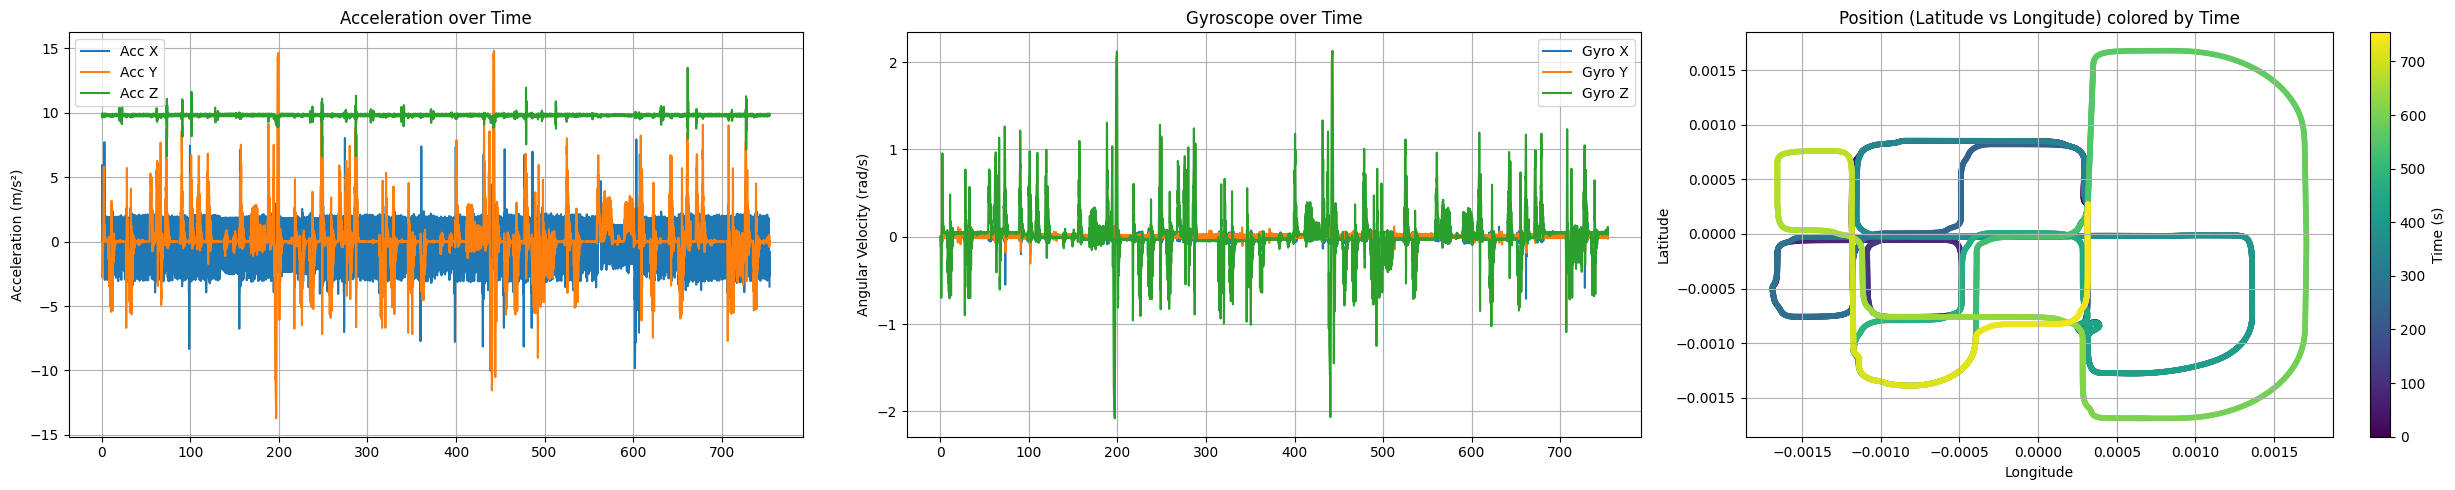

In [30]:
os.makedirs('plot_experiment1', exist_ok=True)
id = 'veh_carla4'
plot_df(pd.read_csv(f'data_experiment1/{id}.csv'), save_path=f'plot_experiment1/{id}.png')

## Collecting data following route

In [28]:
# timestamp: simulation time - s
# acc: m/s^2
# gyro: rad/s
# compass: rad
imu_df = pd.DataFrame(columns=['timestamp', 'acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z', 'compass'])

# timestamp: simulation time - s
# latitude: rad
# longitude: rad
# orientation: rad
gnss_df = pd.DataFrame(columns=['timestamp', 'latitude', 'longitude'])

vehicle = vehicles_bp[0]
agent_behavior = 'aggressive'  # options: 'normal', 'aggressive', etc.

print(f"Vehicle will go to the following places: {places_routine}")
follow_route(vehicle, [IMU_bp, GNSS_bp], spawn_points, sps_routine, agent_behavior=agent_behavior, n_vehicles=0, sampling_res=1, fixed_spectator=True, draw_debug_route=True, render=True)

Vehicle will go to the following places: ['home', 'school', 'gym', 'university', 'cafe', 'work', 'gym', 'home', 'school', 'cafe', 'bar', 'theater', 'restaurant', 'bar', 'home', 'home', 'home']
Showing multiple routes
IMU sensor attached.
GNSS sensor attached.
Path up to Transform(Location(x=-95.266602, y=-95.037498, z=0.300000), Rotation(pitch=0.000000, yaw=-179.913696, roll=0.000000)) completed.
New route set from Transform(Location(x=-95.266602, y=-95.037498, z=0.300000), Rotation(pitch=0.000000, yaw=-179.913696, roll=0.000000)) to Transform(Location(x=-188.055908, y=55.289810, z=0.600000), Rotation(pitch=0.000000, yaw=-90.015808, roll=0.000000)).


: 

In [28]:
create_new_df = True
if create_new_df:
    dfs = {}

dfs[agent_behavior] = pd.merge_asof(imu_df.drop(columns=['acc_z']), gnss_df, on='timestamp', direction='nearest')[3:] # Drop first 3 rows to avoid absurd values
dfs[agent_behavior]['timestamp'] = dfs[agent_behavior]['timestamp'] - dfs[agent_behavior]['timestamp'].iloc[0] # Normalize time to start from 0

## Colleting data without following route

### In synchronous mode, all sensors tick at the same time

In [ ]:
# timestamp: simulation time - s
# acc: m/s^2
# gyro: rad/s
# compass: rad
imu_df = pd.DataFrame(columns=['timestamp', 'acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z', 'compass'])

# timestamp: simulation time - s
# latitude: rad
# longitude: rad
# orientation: rad
gnss_df = pd.DataFrame(columns=['timestamp', 'latitude', 'longitude'])

ego_bp = vehicles_bp[0]
ego_bp.set_attribute('role_name', 'ego')  # Important for carlaviz
ego_vehicle = world.try_spawn_actor(ego_bp, random.choice(spawn_points))

GNSS = world.spawn_actor(GNSS_bp, carla.Transform(carla.Location(z=2)), attach_to=ego_vehicle)
IMU = world.spawn_actor(IMU_bp, carla.Transform(carla.Location(z=2)), attach_to=ego_vehicle)

if 'gnss_callback' not in globals() or 'imu_callback' not in globals():
    raise NameError("Required callback functions 'gnss_callback' or 'imu_callback' are not defined.")

GNSS.listen(lambda data: gnss_callback(data))
IMU.listen(lambda data: imu_callback(data))

settings = world.get_settings()
settings.fixed_delta_seconds = 0.05  # Set the fixed delta time
settings.synchronous_mode = True  # Enable sync mode
world.apply_settings(settings)



simulate_time = 10 # seconds
# Run simulation
try:
    for i in range(Hz*simulate_time):
        world.tick()  # Step the simulation, all sensors will be updated.

        # Follow the ego vehicle
        transform = ego_vehicle.get_transform()
        transform.location.z = 4
        spectator.set_transform(transform)

        # time.sleep(1/Hz)


except KeyboardInterrupt:
    print('Stopped by user')

finally:
    GNSS.destroy()
    IMU.destroy()
    settings.synchronous_mode = False  # Disable sync mode
    world.apply_settings(settings)

NameError: name 'Hz' is not defined

## Plot sensors

In [29]:
def plot_sensors(df, start_time = 0, end_time = 0, gnss=True):

    fig, ax = plt.subplots(2, 2, figsize=(20, 10))
    ax = ax.flatten()
    if end_time == 0:
        end_time = len(df['timestamp'])
    if end_time > len(df['timestamp']):
        end_time = len(df['timestamp'])
    
    start_index = df['timestamp'].searchsorted(start_time, side='left')
    end_index = df['timestamp'].searchsorted(end_time, side='right')

    timestamp = df['timestamp'][start_index:end_index] # Normalize time to start from 0

    ax[0].plot(timestamp, df['acc_x'][start_index:end_index], label='acc_x')
    ax[0].plot(timestamp, df['acc_y'][start_index:end_index], label='acc_y')
    if 'acc_z' in df.columns:
        ax[0].plot(timestamp, df['acc_z'], label='acc_z')
    ax[0].set_title('Accelerometer')
    ax[0].set_xlabel('Time [s]')
    ax[0].set_ylabel('Acceleration [m/s^2]')
    ax[0].legend()

    ax[1].plot(timestamp, df['gyro_x'][start_index:end_index], label='gyro_x')
    ax[1].plot(timestamp, df['gyro_y'][start_index:end_index], label='gyro_y')
    ax[1].plot(timestamp, df['gyro_z'][start_index:end_index], label='gyro_z')
    ax[1].set_title('Gyroscope')
    ax[1].set_xlabel('Time [s]')
    ax[1].set_ylabel('Angular velocity [rad/s]')
    ax[1].legend()

    ax[2].plot(timestamp, df['compass'][start_index:end_index], label='compass')
    ax[2].set_title('Compass')
    ax[2].set_xlabel('Time [s]')
    ax[2].set_ylabel('Heading [rad]')
    ax[2].legend()

    if gnss:
        ax[3].plot(df['latitude'], df['longitude'], label='latitude vs longitude')
        # ax[3].plot(timestamp, df['latitude'][start_index:end_index], label='latitude')
        # ax[3].plot(timestamp, df['longitude'][start_index:end_index], label='longitude')
        ax[3].set_title('GNSS')
        ax[3].set_xlabel('Time [s]')
        ax[3].set_ylabel('Position [rad]')
        ax[3].legend()

    plt.show()

In [26]:
dfs['normal'] = pd.read_csv('out/normal_behavior_data.csv')
dfs['aggressive'] = pd.read_csv('out/aggressive_behavior_data.csv')

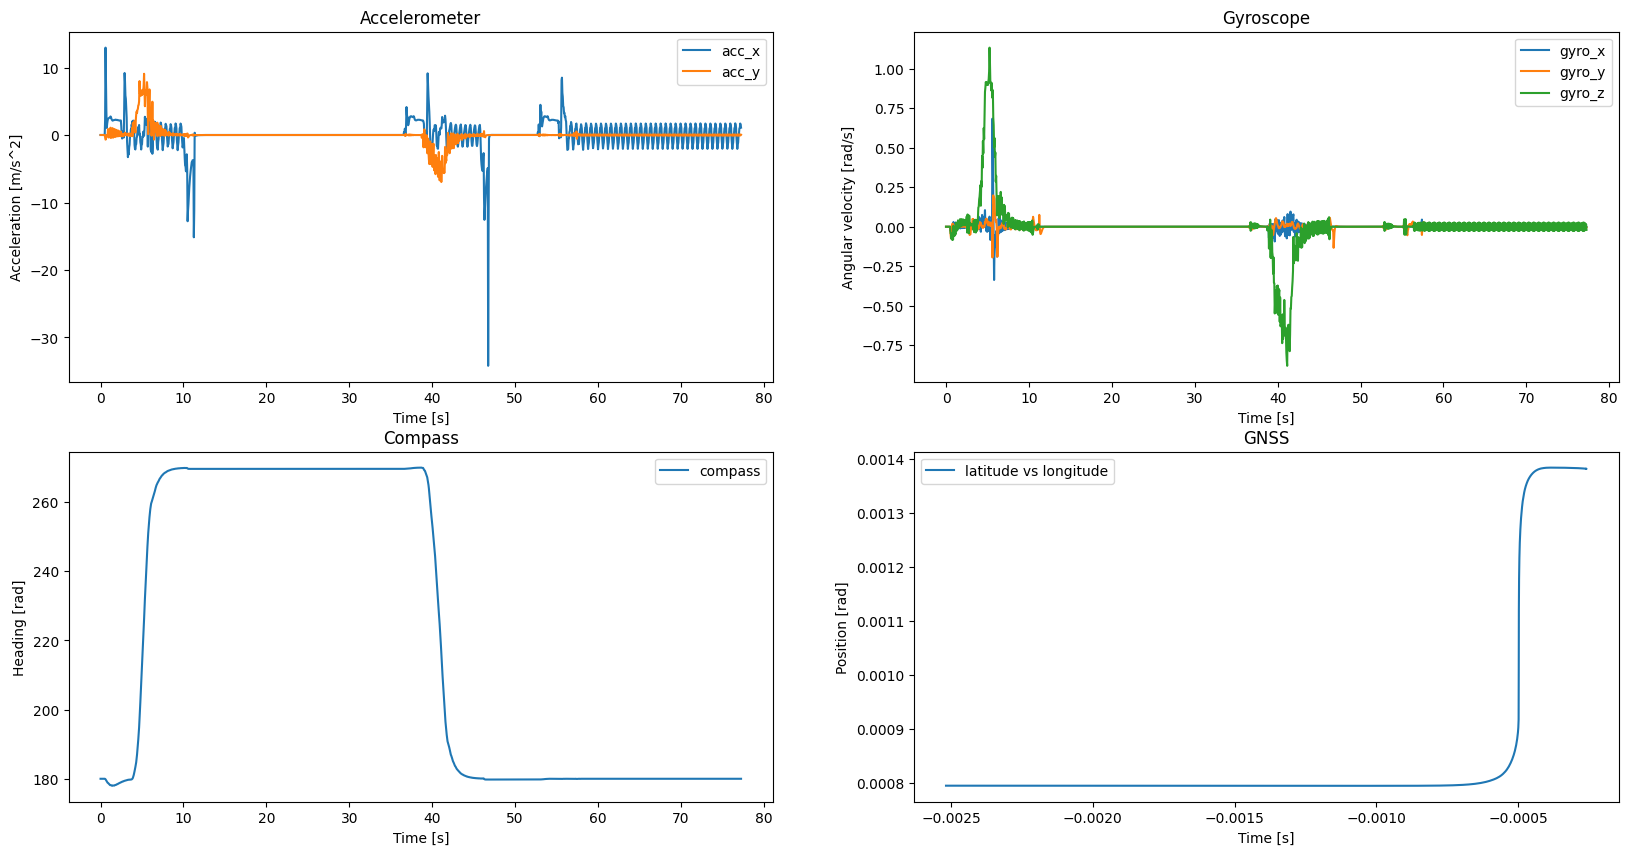

In [32]:
plot_sensors(dfs['aggressive'], start_time=0, end_time=0, gnss=True)

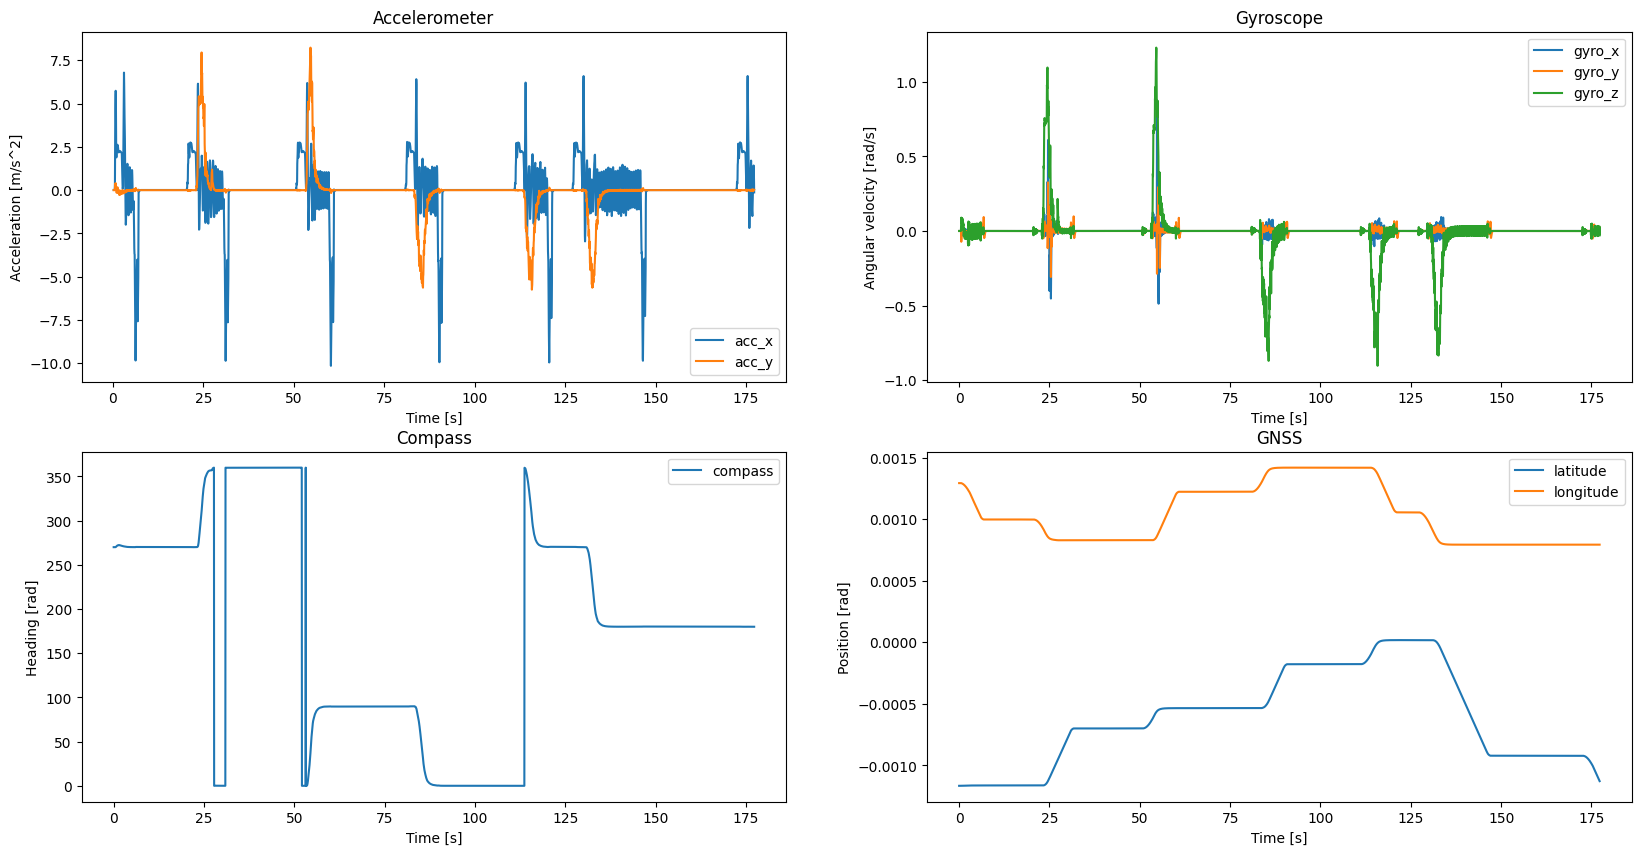

In [61]:
rolling = dfs['normal'].copy()
rolling['acc_x'] = rolling['acc_x'].rolling(window=5).mean()
rolling['acc_y'] = rolling['acc_y'].rolling(window=5).mean()

plot_sensors(rolling, start_time=0, end_time=0, gnss=True)

In [57]:
from scipy.signal import butter, lfilter

# Butterworth filter setup
def butter_lowpass(cutoff, fs, order=3):
    nyq = 0.5 * fs  # Nyquist Frequency
    normal_cutoff = cutoff / nyq
    return butter(order, normal_cutoff, btype='low', analog=False)

def lowpass_filter(data, cutoff=2.0, fs=20.0, order=3):
    b, a = butter_lowpass(cutoff, fs, order)
    return lfilter(b, a, data)

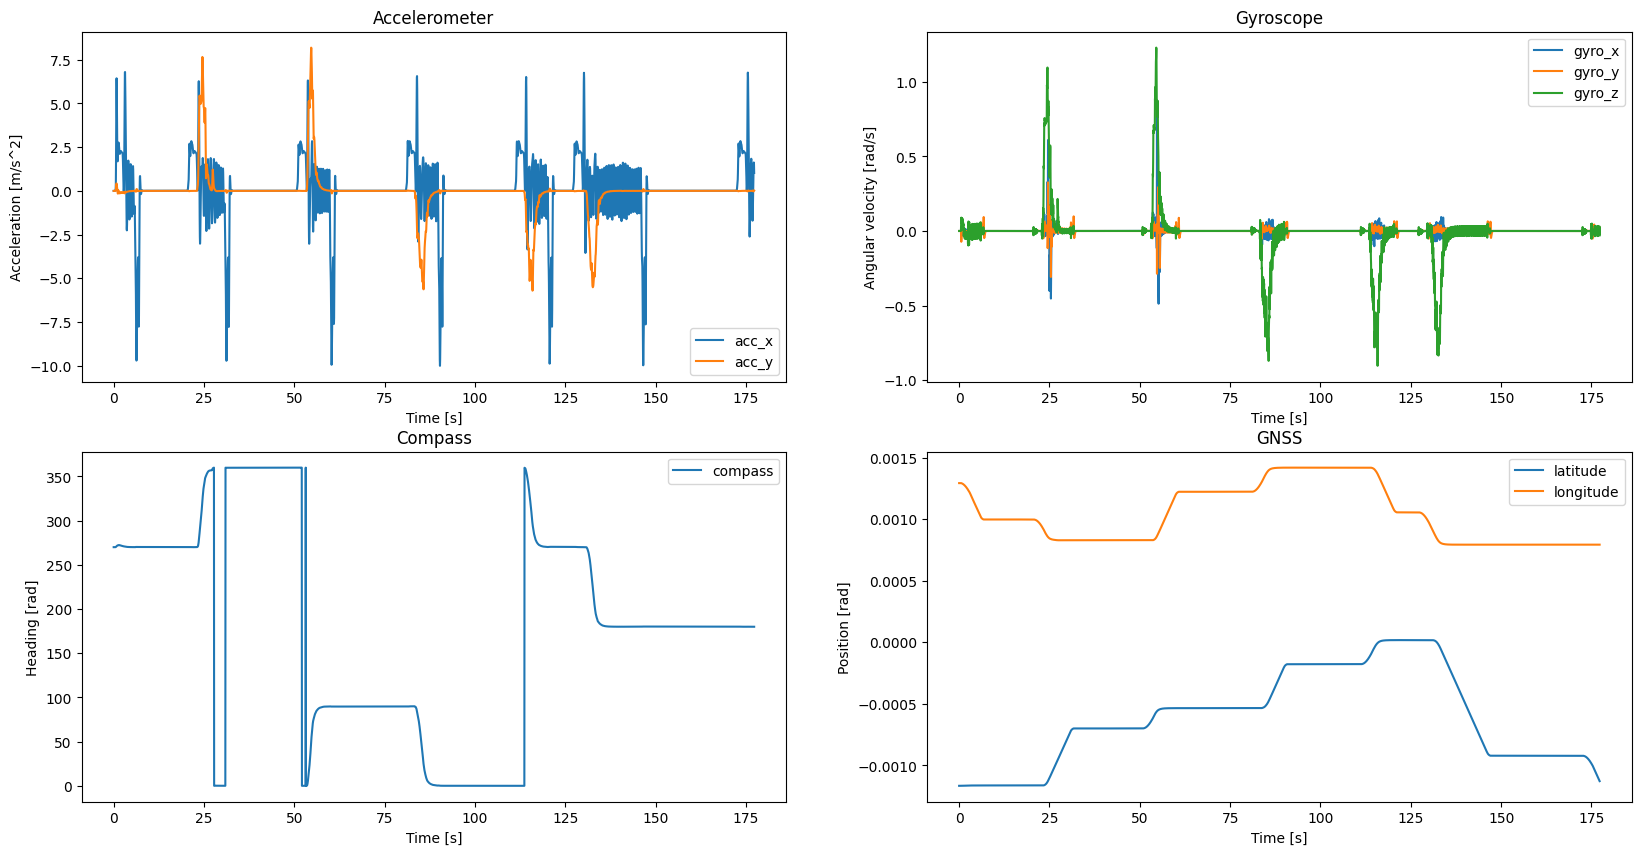

In [60]:
low_pass = dfs['normal'].copy()
low_pass['acc_x'] = lowpass_filter(low_pass['acc_x'], cutoff=2.0, fs=20.0, order=3)
low_pass['acc_y'] = lowpass_filter(low_pass['acc_y'], cutoff=2.0, fs=20.0, order=3)

plot_sensors(low_pass, start_time=0, end_time=0, gnss=True)

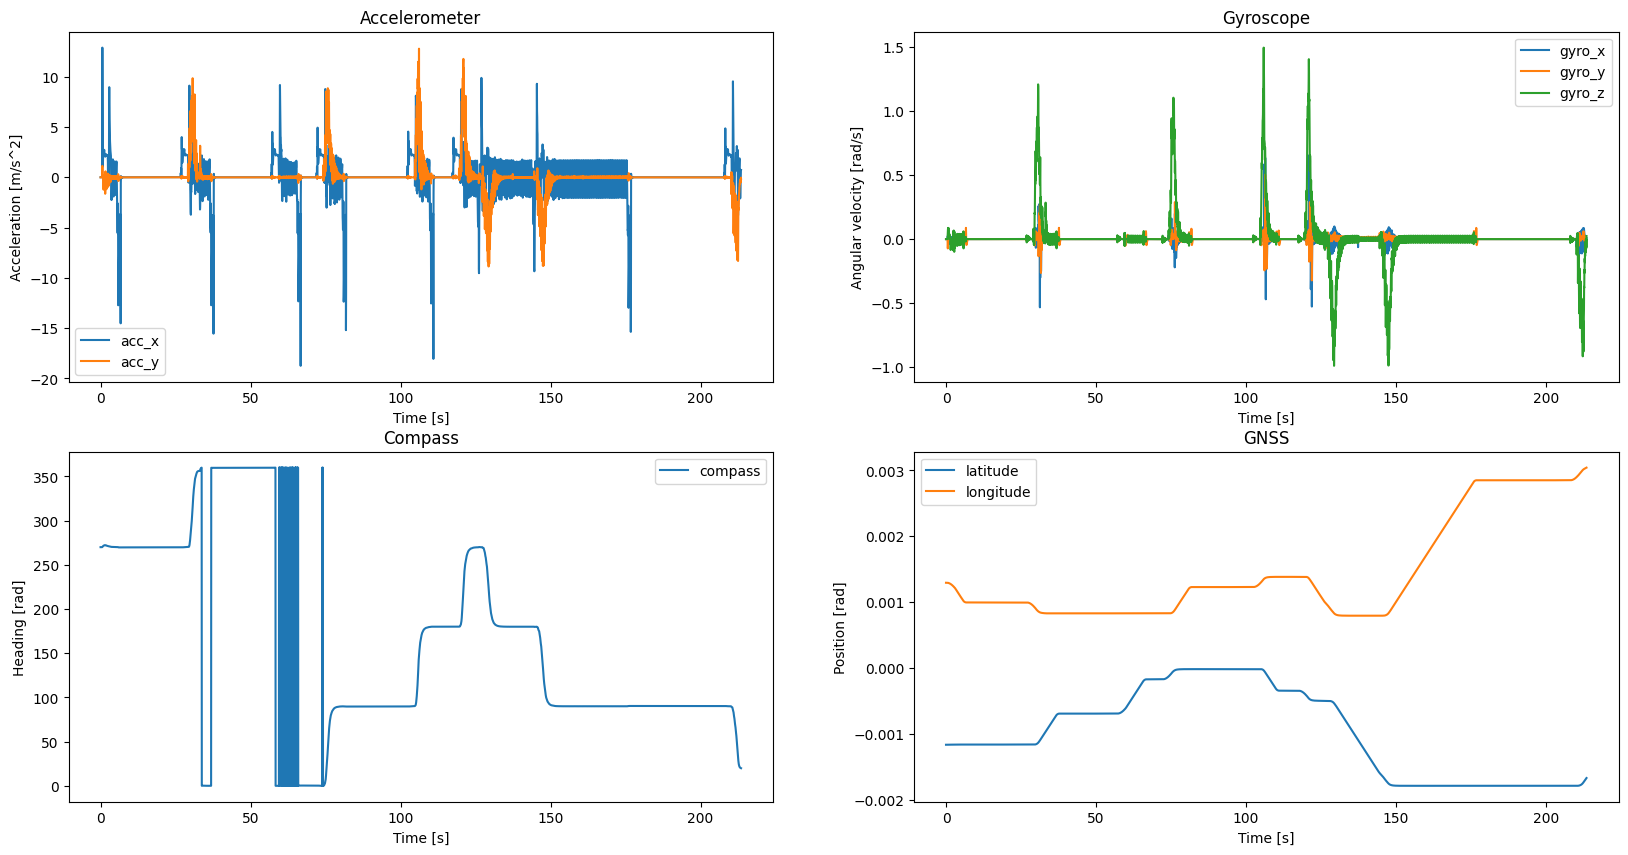

In [48]:
plot_sensors(dfs['aggressive'], start_time=0, end_time=0) # Plot only the last 5 seconds of the simulation

In [57]:
cps = ['acc_x', 'acc_y', 'gyro_x', 'gyro_y', 'gyro_z']
energies = {'normal': [], 'aggressive': []}
for i in cps:
    energy_norm = (dfs['normal'][i] ** 2).sum()
    energy_agg = (dfs['aggressive'][i] ** 2).sum()
    energies['normal'].append(energy_norm)
    energies['aggressive'].append(energy_agg)

    print(f"Agg/Norm energy ratio of {i} signal: {energy_agg/energy_norm}")

Agg/Norm energy ratio of acc_x signal: 1.283414521093272
Agg/Norm energy ratio of acc_y signal: 1.0302839596911226
Agg/Norm energy ratio of gyro_x signal: 1.0451389266131557
Agg/Norm energy ratio of gyro_y signal: 1.1550547350585088
Agg/Norm energy ratio of gyro_z signal: 1.0077943975023227


## Traffic Manager

Vehicle behavior considerations

The TM implements general behavior patterns that must be taken into consideration when you set vehicles to autopilot:

- Vehicles are not goal-oriented, they follow a dynamically produced trajectory and choose a path randomly when approaching a junction. Their path is endless.
- Vehicles' target speed is 70% of their current speed limit unless any other value is set.
- Junction priority does not follow traffic regulations. The TM uses its own priority system at junctions. The resolution of this restriction is a work in progress. In the meantime, some issues may arise, for example, vehicles inside a roundabout yielding to a vehicle trying to get in.
